In [238]:
# import dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
import mysql.connector
from scipy.sparse import csr_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

In [239]:
os.getcwd()

'C:\\Users\\Bilal Ahmad\\Desktop\\House Premium Prediction'

In [240]:
os.chdir("..")

In [241]:
os.getcwd()

'C:\\Users\\Bilal Ahmad\\Desktop'

In [242]:
class DataFromDataBase:
    def __init__(self):
        try:
            # Establish database connection
            self.conn = mysql.connector.connect(
                host="127.0.0.1",
                user= "root",
                password= "password",
                database= "house_insrance" 
            )
            # Create a cursor
            self.cursor = self.conn.cursor()
            print("Database connection is successfully made!")
            
        except Exception as e:
            print(e)
    
    def fetch_dataset(self):
        try:
            
            # Create directory for storing the data
            os.makedirs("data", exist_ok=True)
            filepath = "data/data.csv"
            
            # Fetch the data from the table
            self.cursor.execute("""
                        SELECT * FROM `house_insurance_data.csv`                
            """)
            data = self.cursor.fetchall()

            # Fetch column names
            column_names = [i[0] for i in self.cursor.description]
            
            # Convert the data to a DataFrame
            df = pd.DataFrame(data, columns=column_names)
            
            # Save the data to CSV
            df.to_csv(filepath, index=False)
            print(f"Data successfully saved to {filepath}")
            
        except Exception as e:
            print(e)


In [243]:
obj= DataFromDataBase()
obj.fetch_dataset()

Database connection is successfully made!
Data successfully saved to data/data.csv


In [244]:
data= pd.read_csv("data/data.csv")

In [245]:
data.head(4)

,House Age,Construction Type,Marital Status,Number of Bedrooms,Coverage Type,Premium
0,14,Wood,Single,4,Standard,2264.849771
1,90,Brick,Single,4,Premium,4281.548430
2,39,Concrete,Divorced,2,Standard,3714.441121
3,27,Brick,Single,3,Basic,2032.018546


In [246]:
data.rename(columns={"House Age": "house_age", "Construction Type": "construction_type", "Marital Status": "matrial_status", "Number of Bedrooms": "number_of_bedrooms", "Coverage Type": "coverage_type"}, inplace=True)

In [247]:
data.head(3)

,house_age,construction_type,matrial_status,number_of_bedrooms,coverage_type,Premium
0,14,Wood,Single,4,Standard,2264.849771
1,90,Brick,Single,4,Premium,4281.548430
2,39,Concrete,Divorced,2,Standard,3714.441121


In [248]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   house_age           1000 non-null   int64  
 1   construction_type   1000 non-null   object 
 2   matrial_status      1000 non-null   object 
 3   number_of_bedrooms  1000 non-null   int64  
 4   coverage_type       1000 non-null   object 
 5   Premium             1000 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


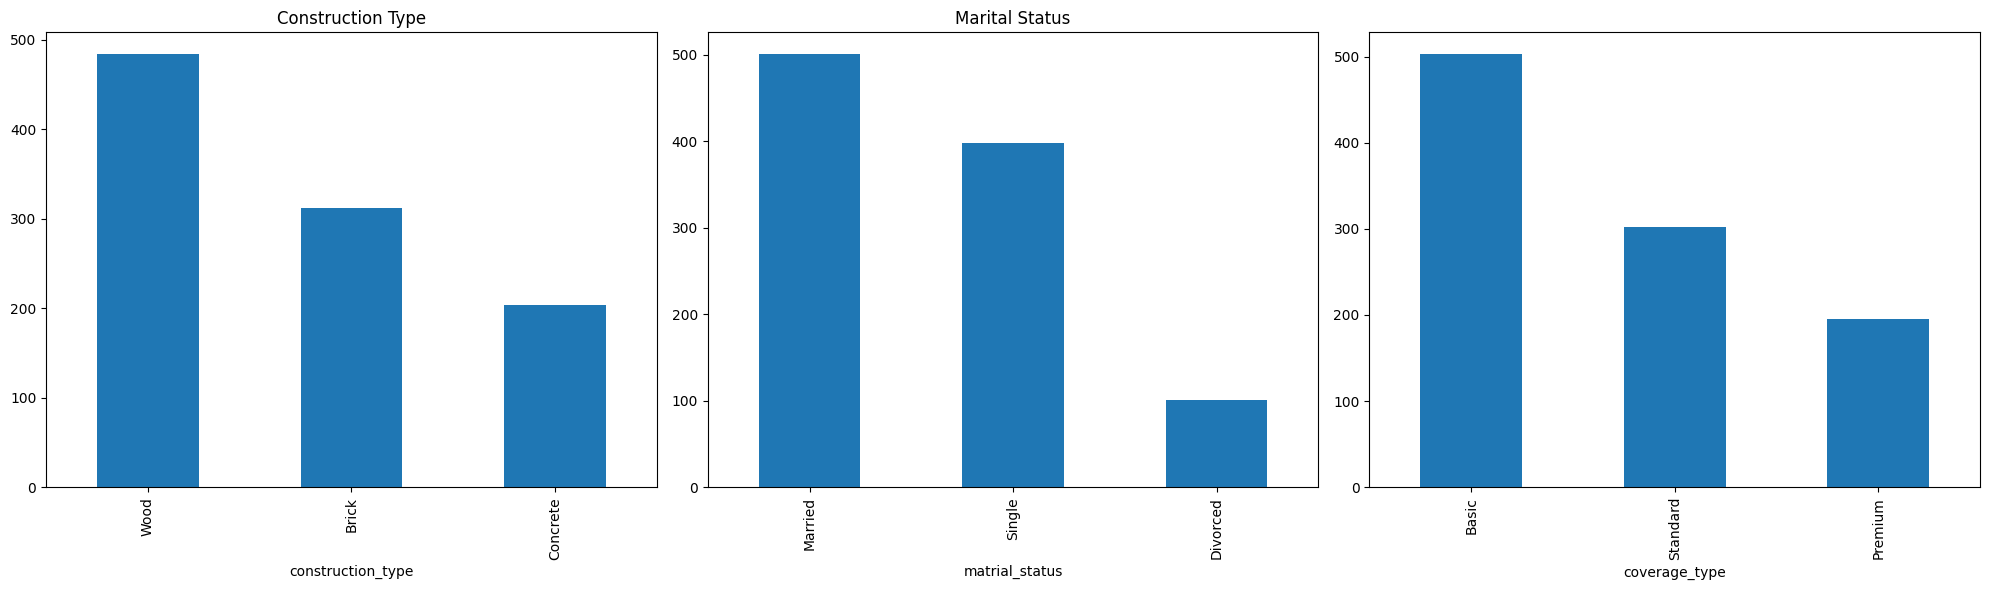

In [249]:
plt.figure(figsize=(20,6))

plt.subplot(131)
data["construction_type"].value_counts().plot(kind="bar")
plt.title("Construction Type")

plt.subplot(132)
data["matrial_status"].value_counts().plot(kind="bar")
plt.title("Marital Status")

plt.subplot(133)
data["coverage_type"].value_counts().plot(kind="bar")
plt.tight_layout()

# Show the plot
plt.show()

<Axes: xlabel='Premium', ylabel='Density'>

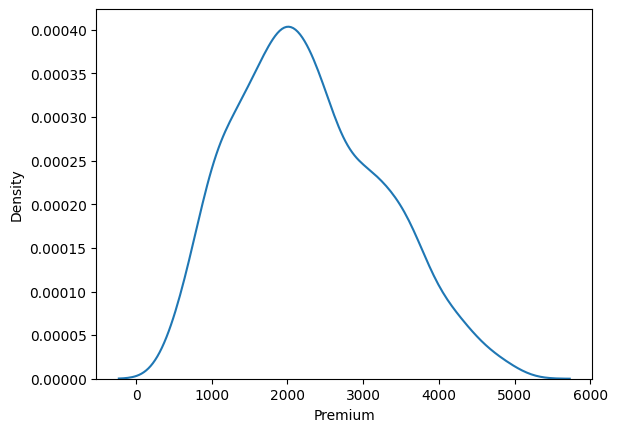

In [250]:
sns.kdeplot(data=data, x="Premium")

In [251]:
x = data.drop(columns="Premium", axis=1)
y = data["Premium"]

In [252]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=0.25, random_state=42)

In [253]:
x_train_cat_cols= x_train.select_dtypes(include="object")
x_test_cat_cols= x_test.select_dtypes(include="object")

In [254]:
encoder= OneHotEncoder(sparse_output=False, handle_unknown="ignore")

In [255]:
cat_cols = x.select_dtypes(include="object").columns
num_cols = x.select_dtypes(exclude="object").columns

num_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]
)

preprocessor = ColumnTransformer([
    ("num_pipeline", num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)   
])

x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)


In [256]:
# # Transform the categorical columns
# x_train_encoded = encoder.fit_transform(x_train_cat_cols)
# x_test_encoded = encoder.transform(x_test_cat_cols)

# # Now create DataFrames with the correct number of columns
# x_train_encoded_df = pd.DataFrame(x_train_encoded, columns=encoder.get_feature_names_out())
# x_test_encoded_df = pd.DataFrame(x_test_encoded, columns=encoder.get_feature_names_out())

# # Drop categorical columns from the original dataset
# selected_train = x_train.drop(columns=x_train_cat_cols.columns, axis=1)
# selected_test = x_test.drop(columns=x_test_cat_cols.columns, axis=1)

# # Reset indices to avoid NaN values during concatenation
# x_train_encoded_df.reset_index(drop=True, inplace=True)
# x_test_encoded_df.reset_index(drop=True, inplace=True)
# selected_train.reset_index(drop=True, inplace=True)
# selected_test.reset_index(drop=True, inplace=True)

# # Concatenate the encoded columns with the original numeric columns
# x_train = pd.concat([x_train_encoded_df, selected_train], axis=1)
# x_test = pd.concat([x_test_encoded_df, selected_test], axis=1)

In [257]:
x_train

array([[-0.62031222, -0.98309758,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.24738043, -0.98309758,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 2.24684611,  2.59614119,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.58691234,  0.8065218 ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2851062 , -0.08828789,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.65803799,  1.7013315 ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

In [258]:
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "XGBRegressor": XGBRegressor(),
    "MLPRegressor": MLPRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "LGBMRegressor": LGBMRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor()
}

In [259]:
results= []
for model_name, model in models.items():
    model= model.fit(x_train, y_train)
    y_pred= model.predict(x_test)
    r2= r2_score(y_test, y_pred)
    mse= mean_squared_error(y_test, y_pred)
    mae= mean_absolute_error(y_test, y_pred)
    results.append([model_name, r2, mse, mae])

resultant_df= pd.DataFrame(results, columns=["model", "r2_score", "mse", "mae"])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 11
[LightGBM] [Info] Start training from score 2292.019311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [260]:
# Find the model with the best R² score (highest)
best_r2_model = resultant_df[resultant_df["r2_score"] == resultant_df["r2_score"].max()]

# Find the model with the lowest MSE
best_mse_model = resultant_df[resultant_df["mse"] == resultant_df["mse"].min()]

# Find the model with the lowest MAE
best_mae_model = resultant_df[resultant_df["mae"] == resultant_df["mae"].min()]

# Display results
print("Best R² model:")
print(best_r2_model)

print("\nBest MSE model:")
print(best_mse_model)

print("\nBest MAE model:")
print(best_mae_model)


Best R² model:
   model  r2_score        mse         mae
1  Lasso  0.890273  96262.556  247.122873

Best MSE model:
   model  r2_score        mse         mae
1  Lasso  0.890273  96262.556  247.122873

Best MAE model:
   model  r2_score           mse         mae
3  Ridge  0.890145  96374.559074  247.099669


In [261]:
model= Lasso()
model.fit(x_train, y_train)

Lasso()

In [262]:
#accuracy on training data
x_train_prediction = model.predict(x_train)
training_data_accuracy = r2_score(x_train_prediction, y_train) 
training_data_mse = mean_squared_error(x_train_prediction, y_train)
training_data_mae = mean_absolute_error(x_train_prediction, y_train)

print('R2 on training data : ', training_data_accuracy)
print('MSE on training data : ', training_data_mse)
print('MAE on training data : ', training_data_mae)

R2 on training data :  0.8954338888921944
MSE on training data :  89111.17523031165
MAE on training data :  233.1637967748743


In [263]:
#accuracy on training data
x_test_prediction = model.predict(x_test)
testing_data_accuracy = r2_score(x_test_prediction, y_test) 
testing_data_mse = mean_squared_error(x_test_prediction, y_test)
testing_data_mae = mean_absolute_error(x_test_prediction, y_test)

print('R2 on training data : ', testing_data_accuracy)
print('MSE on training data : ', testing_data_mse)
print('MAE on training data : ', testing_data_mae)

R2 on training data :  0.878726088982075
MSE on training data :  96262.5559995807
MAE on training data :  247.12287274644768


In [264]:
# hyperparameter search space
param_distributions = {
    'alpha': np.logspace(-4, 1, 100),   # Regularization strength
    'max_iter': [1000, 2000, 3000, 4000], # Maximum number of iterations
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],    # Tolerance for stopping criteria
    'fit_intercept': [True, False],     # Whether to fit the intercept
    'selection': ['cyclic', 'random']    # The algorithm to use for coordinate descent
}

# initalizing the randomizedsearchcv
random_search = RandomizedSearchCV(
    estimator= model,
    param_distributions=param_distributions,
    n_iter=100,
    scoring="neg_mean_squared_error",
    cv=5,
    random_state= 42,
    n_jobs= -1
    
)

# fit the model
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': array([1.00000000e-04, 1.12332403e-04, 1.26185688e-04, 1.41747416e-04,
       1.59228279e-04, 1.78864953e-04, 2.00923300e-04, 2.25701972e-04,
       2.53536449e-04, 2.84803587e-04, 3.19926714e-04, 3.59381366e-04,
       4.03701726e-04, 4.53487851e-04, 5.09413801e-04, 5.72236766e-04,
       6.42807312e...
       2.78255940e+00, 3.12571585e+00, 3.51119173e+00, 3.94420606e+00,
       4.43062146e+00, 4.97702356e+00, 5.59081018e+00, 6.28029144e+00,
       7.05480231e+00, 7.92482898e+00, 8.90215085e+00, 1.00000000e+01]),
                                        'fit_intercept': [True, False],
                                        'max_iter': [1000, 2000, 3000, 4000],
                                        'selection': ['cyclic', 'random'],
                                        'tol': [0.0001, 0.001, 0.01, 0.1]},
                   random_state=42, scoring='neg_mean_squared_error')

In [265]:
# Initialize a list to store results
results = []

# Iterate through all combinations
for params, mean_score in zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score']):
    # Create a temporary Lasso model with the parameters
    lasso_model = Lasso(**params)
    lasso_model.fit(x_train, y_train)
    
    # Predict and evaluate
    y_pred = lasso_model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Append results to the list
    results.append({
        'params': params,
        'r2_score': r2,
        'mse': mse,
        'mae': mae
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

In [266]:
results_df[results_df["r2_score"] == results_df["r2_score"].max()]

,params,r2_score,mse,mae
57,"{'tol': 0.001, 'selection': 'cyclic', 'max_ite...",0.891044,95586.367903,245.957024


In [267]:
best_params = random_search.best_params_

# Initialize the Lasso model with the best parameters
best_lasso = Lasso(**best_params)

# Fit the model on the training data
best_lasso.fit(x_train, y_train)

# Now you can make predictions using the fitted model
y_pred_best = best_lasso.predict(x_test)

# Evaluate the model's performance
r2_best = r2_score(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)

# Print the evaluation metrics
print("Best Lasso Model Performance:")
print(f"R2 Score: {r2_best}")
print(f"MSE: {mse_best}")
print(f"MAE: {mae_best}")

Best Lasso Model Performance:
R2 Score: 0.8900018656511222
MSE: 96500.28050286522
MAE: 246.71055113518236


In [268]:
random_search.best_params_

{'tol': 0.1,
 'selection': 'random',
 'max_iter': 3000,
 'fit_intercept': True,
 'alpha': np.float64(0.0001)}

In [269]:
#accuracy on training data
x_train_prediction = best_lasso.predict(x_train)
training_data_accuracy = r2_score(x_train_prediction, y_train) 
training_data_mse = mean_squared_error(x_train_prediction, y_train)
training_data_mae = mean_absolute_error(x_train_prediction, y_train)

print('R2 on training data : ', training_data_accuracy)
print('MSE on training data : ', training_data_mse)
print('MAE on training data : ', training_data_mae)

R2 on training data :  0.8962349985877692
MSE on training data :  89120.88739778075
MAE on training data :  233.1486710394448


In [270]:
#accuracy on training data
x_test_prediction = best_lasso.predict(x_test)
testing_data_accuracy = r2_score(x_test_prediction, y_test) 
testing_data_mse = mean_squared_error(x_test_prediction, y_test)
testing_data_mae = mean_absolute_error(x_test_prediction, y_test)

print('R2 on training data : ', testing_data_accuracy)
print('MSE on training data : ', testing_data_mse)
print('MAE on training data : ', testing_data_mae)

R2 on training data :  0.8792802465664258
MSE on training data :  96500.28050286522
MAE on training data :  246.71055113518236


In [271]:
os.chdir(r"C:\Users\Bilal Ahmad\Desktop\House Premium Prediction")

In [272]:
# Save the model to a file
joblib.dump(best_lasso, 'best_lasso_model.pkl')

['best_lasso_model.pkl']

In [273]:
joblib.dump(preprocessor, "preprocessor.pkl")

['preprocessor.pkl']

In [277]:
# Define the input data as a DataFrame with the correct column names
input_data = pd.DataFrame([[12, "Wood", "Divorced", 6, "Premium"]], 
                          columns=['house_age','construction_type', 'matrial_status', 'number_of_bedrooms', 'coverage_type'])

# Load the preprocessor and transform the input data
preprocessor_obj = joblib.load("preprocessor.pkl")
transformed_data = preprocessor_obj.transform(input_data)

# Load the model and make the prediction
model = joblib.load("best_lasso_model.pkl")
prediction = model.predict(transformed_data)

print(prediction)

[3560.67371782]
